# Objectives
- 

In this lab, we would like to make an XGBoost model to study over the ecommerce behavior from multi category store. First, we need to download the data to your local machine, then we will load the data from the local machine onto a Pandas Dataframe.

### Instruction

- Accept the kaggle policy and download the data from here https://www.kaggle.com/code/tshephisho/ecommerce-behaviour-using-xgboost/data
- For the first model building, we'll only use the 2019-Nov csv data (which is still around ~2gb)

In [ ]:
# import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import matplotlib.pyplot as plt
import squarify
import matplotlib.dates as dates
from datetime import datetime

%matplotlib inline

In [3]:
# fill this in with your path (absolute path works as well)
path_to_file = ""
df = pd.read_csv(path_to_file)

Let's do some exploratory analysis on the data!

In [4]:
# take a quick look of the data
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67501979 entries, 0 to 67501978
Data columns (total 9 columns):
event_time       object
event_type       object
product_id       int64
category_id      int64
category_code    object
brand            object
price            float64
user_id          int64
user_session     object
dtypes: float64(1), int64(3), object(5)
memory usage: 4.5+ GB


In [6]:
df.shape

(67501979, 9)

In [7]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

# Know your Customers
How many unique customers visit the site?

In [8]:
visitor = df['user_id'].nunique()
print ("visitors: {}".format(visitor))

visitors: 3696117


# Vistors Daily Trend
Does traffic flunctuate by date?

In [9]:
d = df.loc[:,['event_time','user_id']]

In [10]:
d['event_time'] = d['event_time'].apply(lambda s: str(s)[0:10])

In [11]:
visitor_by_date = d.drop_duplicates().groupby(['event_time'])['user_id'].agg(['count']).sort_values(by=['event_time'], ascending=True)

In [ ]:
x = pd.Series(visitor_by_date.index.values).apply(lambda s: datetime.strptime(s, '%Y-%m-%d').date())
y = visitor_by_date['count']
plt.rcParams['figure.figsize'] = (20,8)

plt.plot(x,y)
plt.show()

### By Category and Product
Which category customers interact the most? What brand the view to most?

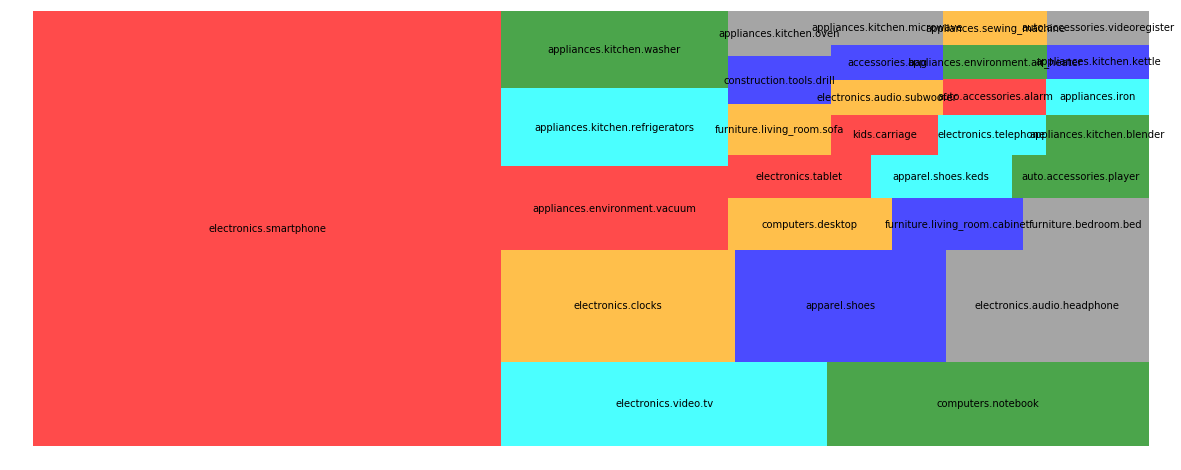

In [13]:
top_category_n = 30
top_category = df.loc[:,'category_code'].value_counts()[:top_category_n].sort_values(ascending=False)
squarify.plot(sizes=top_category, label=top_category.index.array, color=["red","cyan","green","orange","blue","grey"], alpha=.7  )
plt.axis('off')
plt.show()

## event_type = "purchase", what item do customers buy?

Try using 'event_type' == 'purchase' and drop emptry rows to assess which categories customers buy.

In [ ]:
# solutions

## What brands the customers buy?
Try grouping by brand and sort values by the brand name.

In [3]:
# solutions

# Modeling: predict at time of addition to shopping cart if user will purchase a given product or not
### Feature engineering

Restructure the data to feed into the machine learning model. For this use case, I only target the data which customers have "put" the product in the cart.

Furthermore, I add some new features into the training data set:

- category_code_level1: category
- category_code_level2: sub-category
- event_weekday: weekday of the event
- activity_count: number of activity in that session
- is_purchased: whether the put in cart item is purchased

Thus, the training data set contains every non-duplicated cart transaction (within the same session, I only keep one record for a particular product in the cart) with above mentioned new feature. I will use those features, including the original price and brand to predict whether customers will eventually purchase the item in the cart.

In [17]:
df_targets = df.loc[df["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['event_type', 'product_id','price', 'user_id','user_session'])
df_targets["is_purchased"] = np.where(df_targets["event_type"]=="purchase",1,0)
df_targets["is_purchased"] = df_targets.groupby(["user_session","product_id"])["is_purchased"].transform("max")
df_targets = df_targets.loc[df_targets["event_type"]=="cart"].drop_duplicates(["user_session","product_id","is_purchased"])
df_targets['event_weekday'] = df_targets['event_time'].apply(lambda s: str(datetime.strptime(str(s)[0:10], "%Y-%m-%d").weekday()))
df_targets.dropna(how='any', inplace=True)
df_targets["category_code_level1"] = df_targets["category_code"].str.split(".",expand=True)[0].astype('category')
df_targets["category_code_level2"] = df_targets["category_code"].str.split(".",expand=True)[1].astype('category')

In [18]:
cart_purchase_users = df.loc[df["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['user_id'])
cart_purchase_users.dropna(how='any', inplace=True)
cart_purchase_users_all_activity = df.loc[df['user_id'].isin(cart_purchase_users['user_id'])]

**Prepare a dataframe for counting activity in the session**

In [ ]:
activity_in_session = cart_purchase_users_all_activity.groupby(['user_session'])['event_type'].count().reset_index()
activity_in_session = activity_in_session.rename(columns={"event_type": "activity_count"})

In [20]:
del d # free memory

In [21]:
df_targets = df_targets.merge(activity_in_session, on='user_session', how='left')
df_targets['activity_count'] = df_targets['activity_count'].fillna(0)
df_targets.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchased,event_weekday,category_code_level1,category_code_level2,activity_count
0,2019-11-01 00:00:14 UTC,cart,1005014,2053013555631882655,electronics.smartphone,samsung,503.09,533326659,6b928be2-2bce-4640-8296-0efdf2fda22a,0.0,4,electronics,smartphone,1.0
1,2019-11-01 00:03:24 UTC,cart,1801881,2053013554415534427,electronics.video.tv,samsung,488.80,557746614,4d76d6d3-fff5-4880-8327-e9e57b618e0e,1.0,4,electronics,video,25.0
2,2019-11-01 00:03:39 UTC,cart,1005115,2053013555631882655,electronics.smartphone,apple,949.47,565865924,fd4bd6d4-bd14-4fdc-9aff-bd41a594f82e,0.0,4,electronics,smartphone,2.0
3,2019-11-01 00:05:54 UTC,cart,1002542,2053013555631882655,electronics.smartphone,apple,486.80,549256216,dcbdc6e4-cd49-4ee8-95c5-e85f3c618fa1,0.0,4,electronics,smartphone,14.0
4,2019-11-01 00:06:38 UTC,cart,1004856,2053013555631882655,electronics.smartphone,samsung,128.42,513645631,61ceaf50-820a-4858-9a68-bab804d47a22,1.0,4,electronics,smartphone,9.0


## Save new data structure for modeling

In [22]:
df_targets.to_csv('training_data.csv')

In [23]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1408569 entries, 0 to 1408568
Data columns (total 14 columns):
event_time              1408569 non-null object
event_type              1408569 non-null object
product_id              1408569 non-null int64
category_id             1408569 non-null int64
category_code           1408569 non-null object
brand                   1408569 non-null object
price                   1408569 non-null float64
user_id                 1408569 non-null int64
user_session            1408569 non-null object
is_purchased            1408569 non-null float64
event_weekday           1408569 non-null object
category_code_level1    1408569 non-null category
category_code_level2    1408569 non-null category
activity_count          1408569 non-null float64
dtypes: category(2), float64(3), int64(3), object(6)
memory usage: 142.4+ MB


In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics

## Resampling training set

In [25]:
is_purcahase_set = df_targets[df_targets['is_purchased']== 1]
is_purcahase_set.shape[0]

522866

In [26]:
not_purcahase_set = df_targets[df_targets['is_purchased']== 0]
not_purcahase_set.shape[0]

885703

In [27]:
n_samples = 500000
is_purchase_downsampled = resample(is_purcahase_set,
                                replace = False, 
                                n_samples = n_samples,
                                random_state = 27)
not_purcahase_set_downsampled = resample(not_purcahase_set,
                                replace = False,
                                n_samples = n_samples,
                                random_state = 27)

In [28]:
downsampled = pd.concat([is_purchase_downsampled, not_purcahase_set_downsampled])
downsampled['is_purchased'].value_counts()

1.0    500000
0.0    500000
Name: is_purchased, dtype: int64

In [29]:
features = downsampled.loc[:,['brand', 'price', 'event_weekday', 'category_code_level1', 'category_code_level2', 'activity_count']]

## Encode categorical variables

In [30]:
features.loc[:,'brand'] = LabelEncoder().fit_transform(downsampled.loc[:,'brand'].copy())
features.loc[:,'event_weekday'] = LabelEncoder().fit_transform(downsampled.loc[:,'event_weekday'].copy())
features.loc[:,'category_code_level1'] = LabelEncoder().fit_transform(downsampled.loc[:,'category_code_level1'].copy())
features.loc[:,'category_code_level2'] = LabelEncoder().fit_transform(downsampled.loc[:,'category_code_level2'].copy())

is_purchased = LabelEncoder().fit_transform(downsampled['is_purchased'])
features.head()

,brand,price,event_weekday,category_code_level1,category_code_level2,activity_count
235095,1042,95.24,1,1,35,9.0
1104998,4,1002.60,3,4,29,5.0
1268236,1088,168.69,2,7,40,20.0
103485,75,500.63,4,7,40,8.0
798825,1088,244.02,6,7,40,8.0


In [31]:
print(list(features.columns))

['brand', 'price', 'event_weekday', 'category_code_level1', 'category_code_level2', 'activity_count']


## Split the data

In [32]:
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    is_purchased, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

## Train the model
Choose learning rate of 0.1 on XGBClassifier.

In [33]:
from xgboost import XGBClassifier
model = XGBClassifier(learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [34]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("fbeta:",metrics.fbeta_score(y_test, y_pred, average='weighted', beta=0.5))

Accuracy: 0.6802166666666667
Precision: 0.6613659969198811
Recall: 0.7386350757661616
fbeta: 0.6807030912073982


## Feature importance
Show feature importance using plot_importance

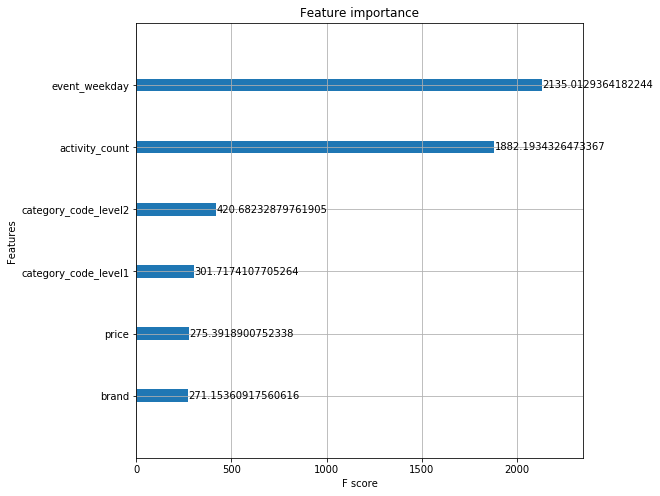

In [35]:
plot_importance(model, max_num_features=10, importance_type ='gain')
plt.rcParams['figure.figsize'] = (40,10)
plt.show()